In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
print(torch.__version__)
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

2.9.1+cu128
True
NVIDIA GeForce RTX 5060 Ti


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 
import torch
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn 
import torch.optim as optim

In [4]:
# set random seed for reproducibility  
torch.manual_seed(42)

In [5]:
# load the dataset 
df = pd.read_csv("fmnist_small.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [6]:
df.iloc[0 , 0]

np.int64(9)

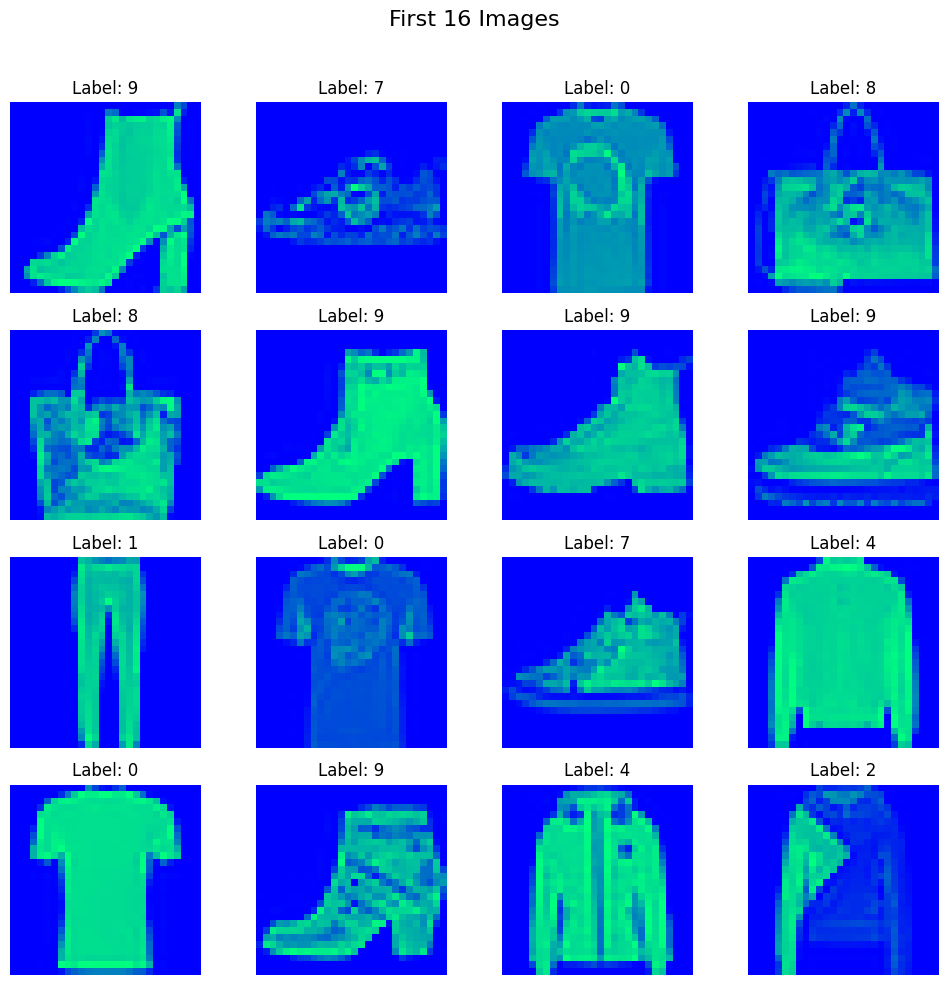

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)  # use suptitle instead of subtitle

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # making 28x28 images
    ax.imshow(img, cmap='winter')  # grayscale for MNIST-like images
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
X = df.iloc[ : , 1: ].values
y = df['label'].to_numpy()

In [9]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [10]:
# scale X 
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
y_train.ndim

1

In [12]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [13]:
y_train.ndim

1

In [14]:
# create Dataset class 
class CustomDataset(Dataset): 
    def __init__(self , features , labels): 
        self.features = torch.tensor(features , dtype=torch.float32)
        self.labels = torch.tensor(labels , dtype=torch.long)  

    def __len__(self): 
        return len(self.features)

    def __getitem__(self , index): 
        return self.features[index] , self.labels[index]


In [15]:
# make the train dataset and test dataaset 
train_dataset = CustomDataset(features = X_train , labels = y_train)
test_dataset = CustomDataset(features = X_test , labels = y_test)

In [16]:
len(train_dataset)

4800

In [17]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [25]:
np.unique(y_train).shape[0]

10

In [26]:
# create train and test data loader 
train_data_loader = DataLoader(dataset = train_dataset , batch_size = 32 , shuffle = True)
test_data_loader = DataLoader(dataset = test_dataset , batch_size = 32 , shuffle = False)

In [27]:
total_targets = np.unique(y_train).shape[0]

In [28]:
# Define ANN Model 
class MyNN(nn.Module): 
    def __init__(self , num_features): 
        super().__init__() 

        self.model = nn.Sequential(
            # input layer where we are getting 784 features
            nn.Linear(in_features = num_features , out_features = 128),
            nn.ReLU(),
            
            nn.Linear(128 , 64),
            nn.ReLU(),
 
            # output layer no need of softmax cause Binary cross entropy already has this one 
            nn.Linear(64 , total_targets) # 10 cause 10 labels
        )

    def forward(self , x): 
       return self.model(x)

In [29]:
# set learning rate and epochs
learning_rate = 0.1
epochs = 100

In [30]:
# initiate the model object
model = MyNN(num_features = X_train.shape[1])
# shift the model from cpu to gpu 
model.to(device)

# loss function 
criterion = nn.CrossEntropyLoss()

# optimizer 
optimizer = optim.SGD(model.parameters() , lr = learning_rate)

In [31]:
# training loop 
for epoch in range(epochs): 
    total_epoch_loss = 0
    
    for batch_features , batch_labels in train_data_loader: 
        # move data to gpu 
        batch_features , batch_labels = batch_features.to(device) , batch_labels.to(device)
        # forward pass 
        outputs = model(batch_features)
        # calculate loss 
        loss = criterion(outputs , batch_labels) 
        total_epoch_loss += loss.item()
        # clear weights and biases
        optimizer.zero_grad()
        # backward pass 
        loss.backward()
        # update gradients
        optimizer.step()
    
    avg_loss_per_epoch = total_epoch_loss / len(train_data_loader)
    print(f"Epoch: {epoch + 1} | Loss: {avg_loss_per_epoch}")

Epoch: 1 | Loss: 1.346769131819407
Epoch: 2 | Loss: 0.7859830691417058
Epoch: 3 | Loss: 0.6728331142663956
Epoch: 4 | Loss: 0.5920069835583369
Epoch: 5 | Loss: 0.5459469129641851
Epoch: 6 | Loss: 0.5051827936371167
Epoch: 7 | Loss: 0.4798990231752396
Epoch: 8 | Loss: 0.4625145532687505
Epoch: 9 | Loss: 0.43489252736171086
Epoch: 10 | Loss: 0.4095153838396072
Epoch: 11 | Loss: 0.38585402896006904
Epoch: 12 | Loss: 0.37250360851486525
Epoch: 13 | Loss: 0.3569496436417103
Epoch: 14 | Loss: 0.3421662206451098
Epoch: 15 | Loss: 0.3227269858618577
Epoch: 16 | Loss: 0.32121127540866534
Epoch: 17 | Loss: 0.3063196787238121
Epoch: 18 | Loss: 0.29647752915819486
Epoch: 19 | Loss: 0.289772839397192
Epoch: 20 | Loss: 0.2749457151442766
Epoch: 21 | Loss: 0.2571949314077695
Epoch: 22 | Loss: 0.2551419394214948
Epoch: 23 | Loss: 0.24139052907625835
Epoch: 24 | Loss: 0.23709541882077853
Epoch: 25 | Loss: 0.23655669791003067
Epoch: 26 | Loss: 0.2142805995295445
Epoch: 27 | Loss: 0.20708116223414738
Epo

In [32]:
# set model evaluation mode 
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [37]:
with torch.no_grad():
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    outputs = model(X_test)          
    _, predicted = torch.max(outputs, dim = 1)

    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()
    accuracy = 100 * correct / total

print(f'Accuracy of the network on the test data: {accuracy:.2f}%')

Accuracy of the network on the test data: 83.33%


## ANN on iris dataset. 

In [5]:
from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset , DataLoader

In [6]:
# 1. Prepare the data 
iris = load_iris()
X , y = iris.data , iris.target
# do the train test split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [7]:
X_train.shape

(120, 4)

In [8]:
# 2. Convert data from numpy to tensor 
X_train = torch.tensor(X_train , dtype = torch.float32)
y_train = torch.tensor(y_train , dtype = torch.long) # CrossEntropyLoss expects Long type for labels
X_test = torch.tensor(X_test , dtype = torch.float32)
y_test = torch.tensor(y_test , dtype = torch.long)

In [9]:
X_test.shape[0]

30

In [10]:
class IrisDataset(Dataset): 
    def __init__(self , features , labels): 
        self.features = features
        self.labels = labels

    def __len__(self): 
        return self.features.shape[0]
    def __getitem__(self , index): 
        sample = self.features[index]
        label = self.labels[index]
        return sample , label

In [ ]:
# 3. make dataset and dataloader 
train_dataset = IrisDataset(X_train , y_train)
train_data_loader = DataLoader(dataset = train_dataset , batch_size = 4 , shuffle = True , pin_memory = True)

In [12]:
# 4. Define the ANN model 
class MulticlassANN(nn.Module): 
    def __init__(self , num_features , num_classes): 
        super(MulticlassANN , self).__init__()

        self.layer1 = nn.Linear(in_features = num_features , out_features = 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features = 128 , out_features = num_classes)
        # No softmax here; it's built into CrossEntropyLoss
    def forward(self , x): 
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out# No softmax here; it's built into CrossEntropyLoss

In [13]:
num_features = X_train.shape[1]
num_classes = len(iris.target_names)
num_features , num_classes

(4, 3)

In [14]:
model_iris = MulticlassANN(num_features , num_classes)
model_iris.to(device)

MulticlassANN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=3, bias=True)
)

In [15]:
# 5. Define loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_iris.parameters() , lr = 0.001)

In [16]:
# 6. Train the model 
num_epochs = 100 
for epoch in range(num_epochs): 
    # train  each batch 
    total_batch_loss = 0
    for inputs , labels in train_data_loader: 
        inputs , labels = inputs.to(device) , labels.to(device)
        # forward pass 
        outputs = model_iris(inputs)
        # loss calculate
        loss = criterion(outputs , labels)
        total_batch_loss += loss.item() 
        # clear gradients
        optimizer.zero_grad()
        # backward pass 
        loss.backward()
        # update gradient
        optimizer.step()

    avg_loss_per_epoch = total_batch_loss / len(inputs)
    print(f"Epoch: {epoch + 1} , avg loss: {avg_loss_per_epoch}")

Epoch: 1 , avg loss: 9.725583747029305
Epoch: 2 , avg loss: 6.532075434923172
Epoch: 3 , avg loss: 4.913085773587227
Epoch: 4 , avg loss: 4.131596103310585
Epoch: 5 , avg loss: 3.450743153691292
Epoch: 6 , avg loss: 3.0602902099490166
Epoch: 7 , avg loss: 2.865702871233225
Epoch: 8 , avg loss: 2.629787279292941
Epoch: 9 , avg loss: 2.4550108686089516
Epoch: 10 , avg loss: 2.3006524965167046
Epoch: 11 , avg loss: 2.141976661980152
Epoch: 12 , avg loss: 2.066294787451625
Epoch: 13 , avg loss: 1.906020300462842
Epoch: 14 , avg loss: 1.9879229729995131
Epoch: 15 , avg loss: 1.7315550651401281
Epoch: 16 , avg loss: 1.7451054267585278
Epoch: 17 , avg loss: 1.6828974727541208
Epoch: 18 , avg loss: 1.6043738164007664
Epoch: 19 , avg loss: 1.4546105219051242
Epoch: 20 , avg loss: 1.4346221331506968
Epoch: 21 , avg loss: 1.3259313236922026
Epoch: 22 , avg loss: 1.2745160283520818
Epoch: 23 , avg loss: 1.2290187701582909
Epoch: 24 , avg loss: 1.2393829855136573
Epoch: 25 , avg loss: 1.15152328321

In [18]:
# set model on evaluation mode 
model_iris.eval()

MulticlassANN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=3, bias=True)
)

In [19]:
X_test[0]

tensor([6.1000, 2.8000, 4.7000, 1.2000])

In [22]:
with torch.no_grad(): 
    # move X_test and y_test to the GPU
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    outputs = model_iris(X_test)
    print(outputs)
    _ , predicted = torch.max(outputs.data , 1) # Get the class with the highest probability index
    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test data: {accuracy:.2f}%')

tensor([[ -7.6450,   1.5793,  -1.4908],
        [ 11.9600,   3.8596, -18.6207],
        [-19.1351,  -2.4310,   7.9532],
        [ -7.6870,   1.2568,  -1.0602],
        [ -7.7096,   1.7296,  -2.0083],
        [ 10.9354,   3.4928, -17.0661],
        [ -3.3457,   2.3124,  -4.6488],
        [-11.3591,  -0.2135,   2.0363],
        [ -9.2045,   0.5897,   0.5315],
        [ -4.6837,   2.3747,  -3.7827],
        [-10.6620,   0.1416,   1.4572],
        [ 10.2885,   3.3469, -16.0279],
        [ 12.2498,   3.6791, -18.8409],
        [ 10.3453,   3.4365, -16.2254],
        [ 11.6009,   3.5703, -17.8856],
        [ -7.4431,   1.5480,  -1.7636],
        [-15.1014,  -1.6171,   5.8196],
        [ -5.1719,   2.1346,  -3.0972],
        [ -7.7120,   1.2490,  -0.8574],
        [-14.8743,  -1.6647,   5.8642],
        [  9.7797,   3.3306, -15.4237],
        [-10.1838,   0.2133,   1.3786],
        [ 10.1218,   3.3576, -15.9099],
        [-14.5357,  -1.4615,   5.4666],
        [-12.8747,   0.3563,   1.4926],
